In [1]:
import numpy as np
import matplotlib.pyplot as plt
import streaming_functions

# Initialize Grid:
nx_total = 100  # num of rows
ny_total = 100 # num of columns

# Iteration steps
n_timesteps = 5

# Initialize weights and discrete direction vectors
weights = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
c = np.array([[0, 1,  0, -1, 0, 1, -1, -1, 1], [0, 0, 1, 0, -1, 1, 1, -1, -1]])

# Initialize grid (add goast points or dry notes to each edge)
#rho = 0.01 * np.ones((nx_total+2, ny_total+2))  # density values
#v = np.zeros((2, nx+2, ny+2))  # average viscosity values
f = np.einsum("i,jk -> ijk", weights, np.ones((nx_total, ny_total)))  # probability density function

# set up parameters for the shear wave
y = np.arange(0, ny_total)
L = ny_total


# set initial conditions case 1
rho = np.zeros((nx_total, ny_total))
rho[:,:] = 1 + 0.5 * np.sin(2*np.pi*y/L)
v = np.zeros((2,nx_total, ny_total))


def recalculate_functions(f):
    """
    Recalculate density and average viscosity at each point after probability density function has been updated.
    See Milestone 1.
    """
    rho = np.einsum("cij -> ij", f)  # density field
    #v_noscale = np.einsum("ijk, il -> ljk", f, c)  # velocity field
    #v = np.einsum("ijk, jk -> ijk", v_noscale, np.reciprocal(rho))  # divide by rho to get averange velocity
    v = 1/rho * np.einsum('ij, ixy -> jxy', c.T, f)

    return rho, v

def calc_equi(f, rho, v, c, weights):
    """
    Calculate the equilibrium distribution function.
    See Milestone 2.
    """
    f_equi = np.zeros_like(f)
    u_abs = np.einsum('inm, inm -> nm',abs(v),abs(v))
    for j in range(9):
        scal = np.einsum('j, jnm -> nm', c.T[j], v)
        f_equi[j] = weights[j] * rho *(1 + 3*scal + 9/2*scal**2- 3/2 * u_abs)
    
    #v_abs = np.einsum("ijk -> jk", v)  # May be negative but will be squared anyway
    #for channel in range(9):
    #    scal = np.einsum("i, ijk -> jk", c[channel], v)
    #    sum_bracket = np.ones_like(scal) + 3 * scal + 9/2 * scal * scal - 3/2 * v_abs * v_abs
    #    f_equi[channel, :, :] = weights[channel] * rho * sum_bracket
    return f_equi

def streaming(f, rho, v, c, weights):
    """
    Pipeline of one complete streaming step.
    """
    f_equi = calc_equi(f, rho, v, c, weights)  # Equlibrium distrubution function

    f += omega * (f_equi - f)  # Relaxation

    c_ij = [[0, 0],[0, 1],[-1, 0],[0, -1], [1, 0], [-1, 1], [-1, -1], [1, -1], [1, 1]]

    for channel in range(9):  # Move channels wrt their direction
        f[channel] = np.roll(f[channel], shift=c_ij[channel], axis=(0,1))
    
    return f

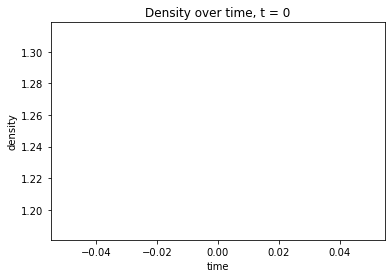

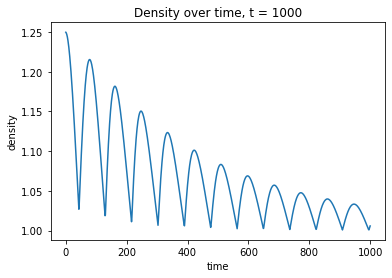

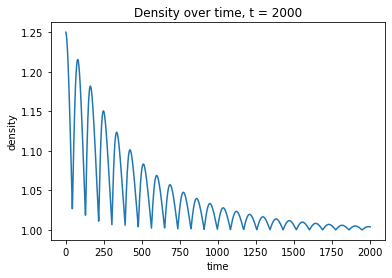

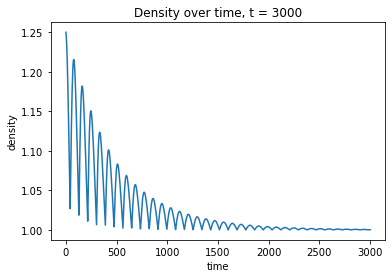

In [2]:
omega = 0.5
amp = []

for t in range(3001):
    f = streaming(f, rho, v, c, weights)

    rho, v = recalculate_functions(f)
    #if t % 100 == 0:
    amp.append(np.max(rho))# np.argmax(rho)[0]
    if t % 1000 == 0:
        fig, ax = plt.subplots()
        plt.plot(np.arange(len(amp)),amp)
        plt.xlabel("time")
        plt.ylabel("density")
        plt.title("Density over time, t = " + str(t))
        plt.show()

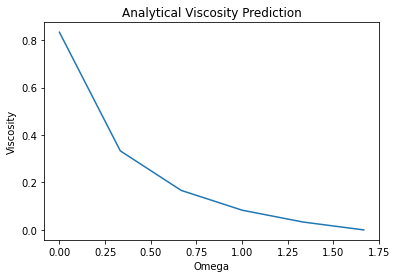

In [3]:
# compute theoretical viscosity
omega = 0.0
viscosity = 0
vis_plot = []
for i in range(6):
    omega += 1/3
    viscosity = 1/3 * (1/omega - 1/2)
    vis_plot.append(viscosity)
plt.plot(np.arange(len(vis_plot))/3, vis_plot)
plt.xlabel("Omega")
plt.ylabel("Viscosity")
plt.title("Analytical Viscosity Prediction")
plt.savefig("viscosity_plot_theoretical.png")
plt.show()

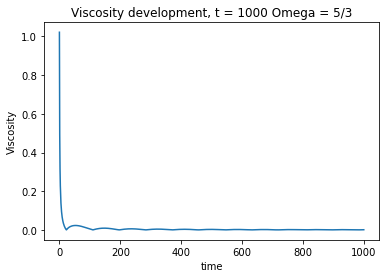

In [6]:
# analytical computation of viscosity using amplitude of decaying shear wave
amp = []
omega = 5/3

for t in range(1,1001):
    
    f = streaming(f, rho, v, c, weights)

    rho, v = recalculate_functions(f)
    
    ampli = np.max(rho)
    nom = (np.log(ampli)/ 0.1)
    denom = (((2*np.pi/L) **2) * t)
    nü = nom/denom
    amp.append(nü)

#plot the resulting viscosity
plt.plot(np.arange(len(amp)), amp)
plt.xlabel("time")
plt.ylabel("Viscosity")
plt.title("Viscosity development, t = " + str(t) + " Omega = 5/3")
plt.show()

In [7]:
# Shear Wave case 2
rho = np.ones((nx_total, ny_total))
v = np.zeros((2, nx_total, ny_total))
epsilon = 0.1
v[0,...] = epsilon * np.sin(2*np.pi*np.arange(0,ny_total)/nx_total)

# analytical computation of viscosity using amplitude of decaying shear wave
amp = []
omega = 5/3

for t in range(1,1001):
    
    f = streaming(f, rho, v, c, weights)

    rho, v = recalculate_functions(f)
    
    ampli = np.max(rho)
    nom = (np.log(ampli)/ 0.1)
    denom = (((2*np.pi/L) **2) * t)
    nü = nom/denom
    amp.append(nü)
    
#plot the resulting viscosity
plt.plot(np.arange(len(amp)), amp)
plt.xlabel("time")
plt.ylabel("Viscosity")
plt.title("Viscosity development, t = " + str(t) + " Omega = 5/3")
plt.show()


NameError: name 'nx' is not defined